# Overview of Volumetric Images
---
## Comparison of 2D and 3D Images

We are all used to 2D digital pictures. When zooming tightly on such an image we are familiar with seeing the "pixels" of the image. As we will see, volumetric images are just a stack of 2D images, and the pixels are usually called "voxels" indicating they are a "volume element". 

Color 2D images are just a massive array of pixels, each containing a numerical value indicating its color. In fact, color images are a 3 separate images with each one indicating the intensity of the Red, Green, and Blue (RGB) at each location. When these 3 colors are mixed together they can combine to make all possible colors. So even 2D image are actually 3D arrays. 

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data


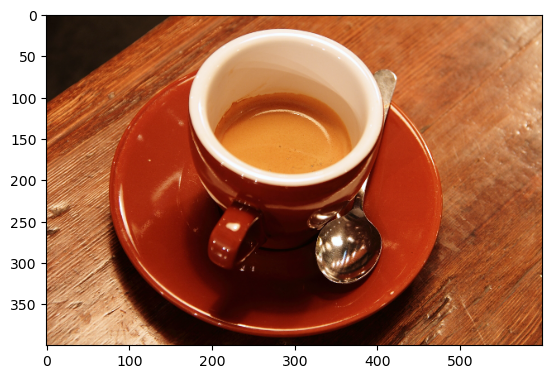

In [75]:
im = data.coffee()
plt.imshow(im);


### Color Images
---
As mentioned, color images are actually 3 images stacked together:

In [76]:
print(im.shape)


(400, 600, 3)


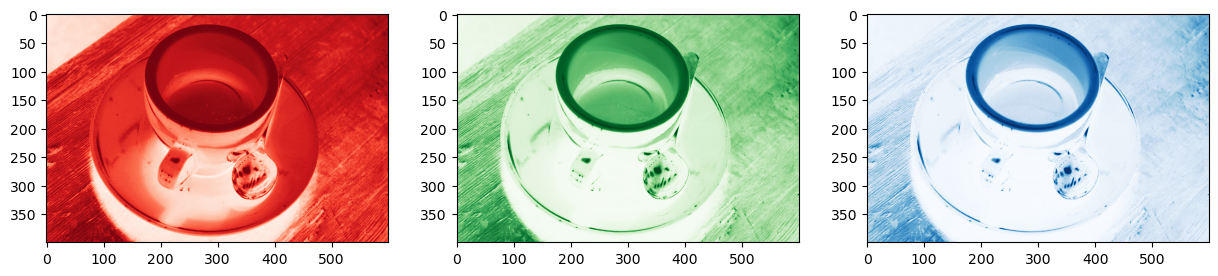

In [77]:
fig, ax = plt.subplots(1, 3, figsize=[15, 5])
ax[0].imshow(im[..., 0], cmap=plt.cm.Reds)
ax[1].imshow(im[..., 1], cmap=plt.cm.Greens)
ax[2].imshow(im[..., 2], cmap=plt.cm.Blues);


### Grayscale Images
---
When dealing with 'technical' or 'scientific' images, we usually only want 'grayscale' images where the color imformation is discarded and we're just left with some scalar intensity value at each location. 

(400, 600)


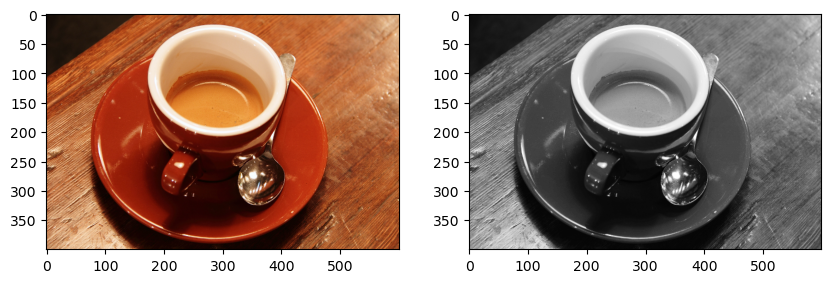

In [78]:
from skimage.color import rgb2gray
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
ax[0].imshow(im)
im2 = rgb2gray(im)
print(im2.shape)
ax[1].imshow(im2, cmap=plt.cm.gray);


Zooming in closely to a spot in the 2D grayscale images reveals the pixels, which contain scalar values:

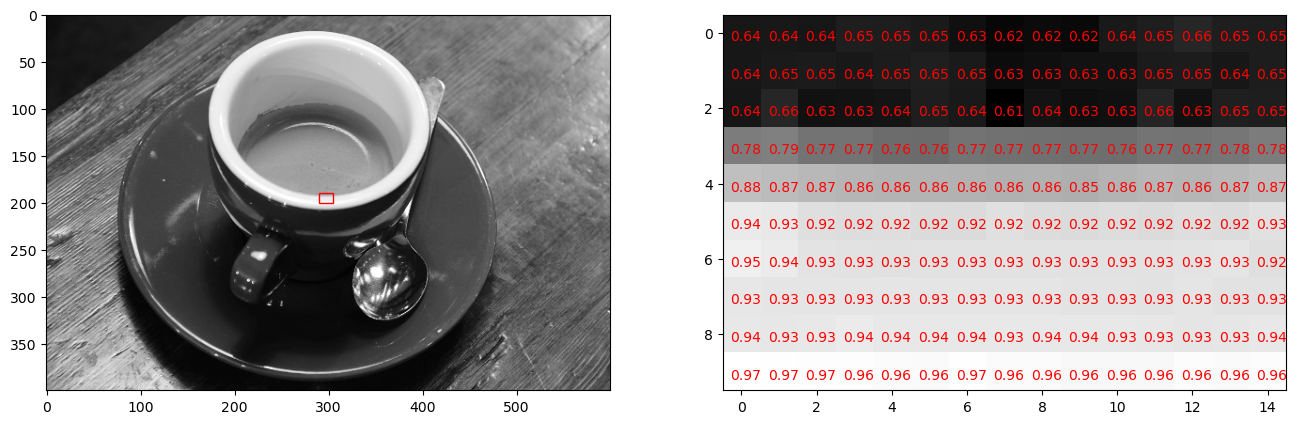

In [79]:
from skimage.color import rgb2gray
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['text.color'] = 'red'

fig, ax = plt.subplots(1, 2, figsize=[16, 8])

ax[0].imshow(im2, cmap=plt.cm.gray)
rect = patches.Rectangle((290, 190), 15, 10, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

temp = im2[190:200, 290:305]
ax[1].imshow(temp, cmap=plt.cm.gray)

x, y = np.meshgrid(range(temp.shape[0]), range(temp.shape[1]))
x = x.flatten()
y = y.flatten()
for i, j in zip(x, y):
    ax[1].annotate(np.around(temp[i, j], decimals=2), xy=(j-0.3, i+0.2))
    

## 3D or Volumetric Images
---
Now let's look at a 3D image. The ``imageio`` package is very helpful for reading in different file types.  Volumetric images are often stored as "TIFF" images since these natively support multiple layers and are universally recognized as an image format. A small section of a sandstone is included in this repository:

In [87]:
import imageio
im = imageio.volread('images/sandstone.tif')
im.shape


(250, 250, 50)

When viewing a 3D image using tools normally meand for 2D images, be sure to extract a single slice:

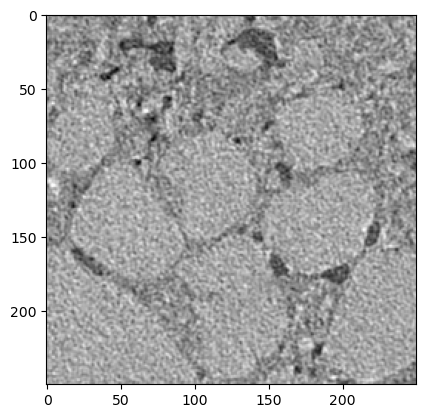

In [88]:
plt.imshow(im[..., 25], cmap=plt.cm.gray);


Here we can see solid grains, dark voids, and some intermediate intensity material which is probably clay.  This is classified as "unresolved porosity" since we can't see the pores but we know they are there.

The above image is slice 25 from a stack of 50 slices. There is not a simple way to visualize 3D images in Jupyter notebooks, so we will improvise:

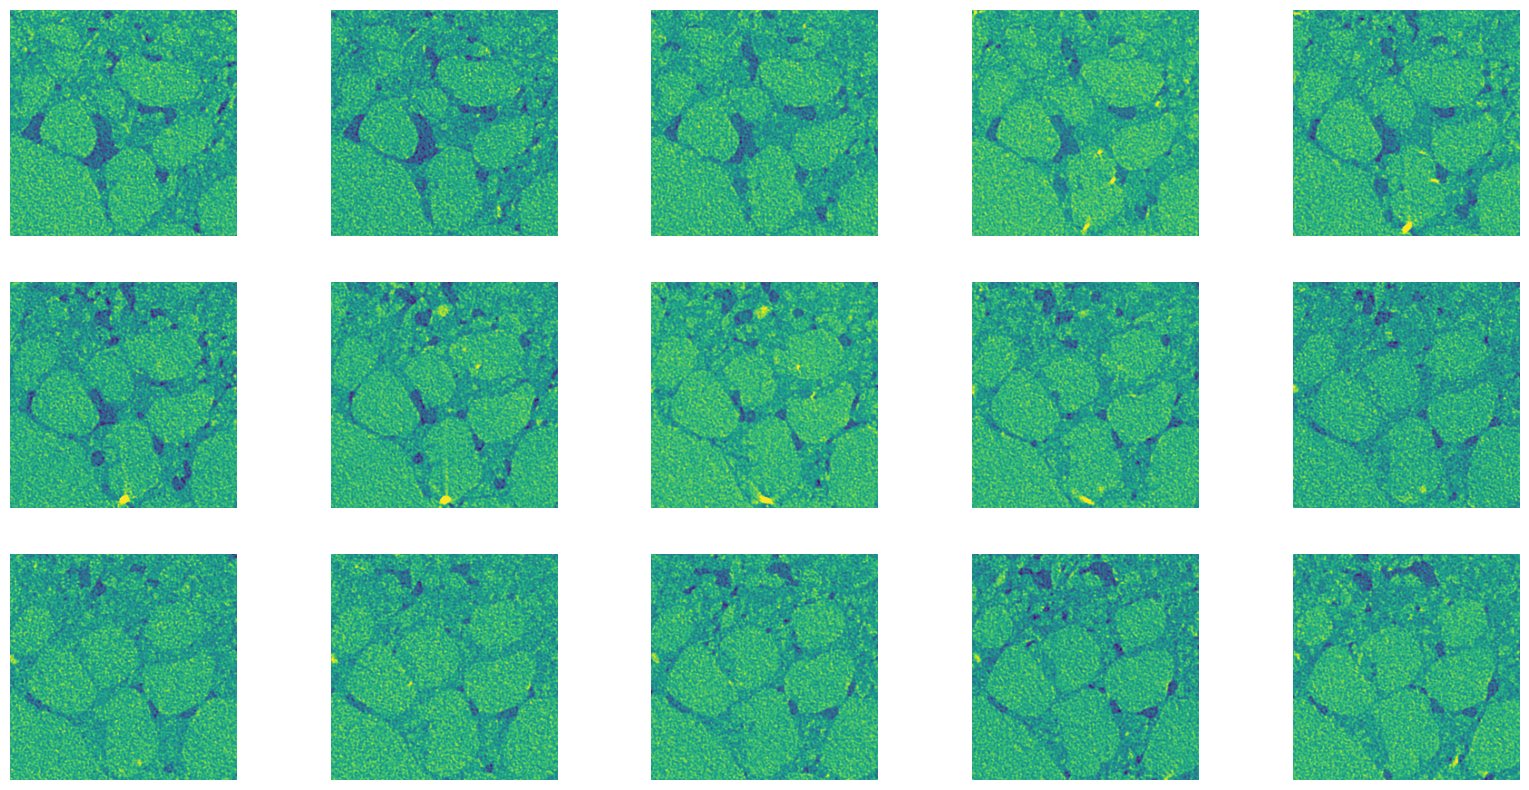

In [89]:
import porespy as ps
N, M = 3, 5
fig, ax = plt.subplots(N, M, figsize=[20, 10])
k = 0
for i in range(N):
    for j in range(M):
        ax[i][j].imshow(im[..., k])
        ax[i][j].axis(False)
        k += 2
        

## Using External Tool to Visualize
---
There are several different packages which can be used to visualize 3D tiff images.  Paraview is "FOSS" maintained by US National Labs.  Here is an example of the type of output you can get from this:

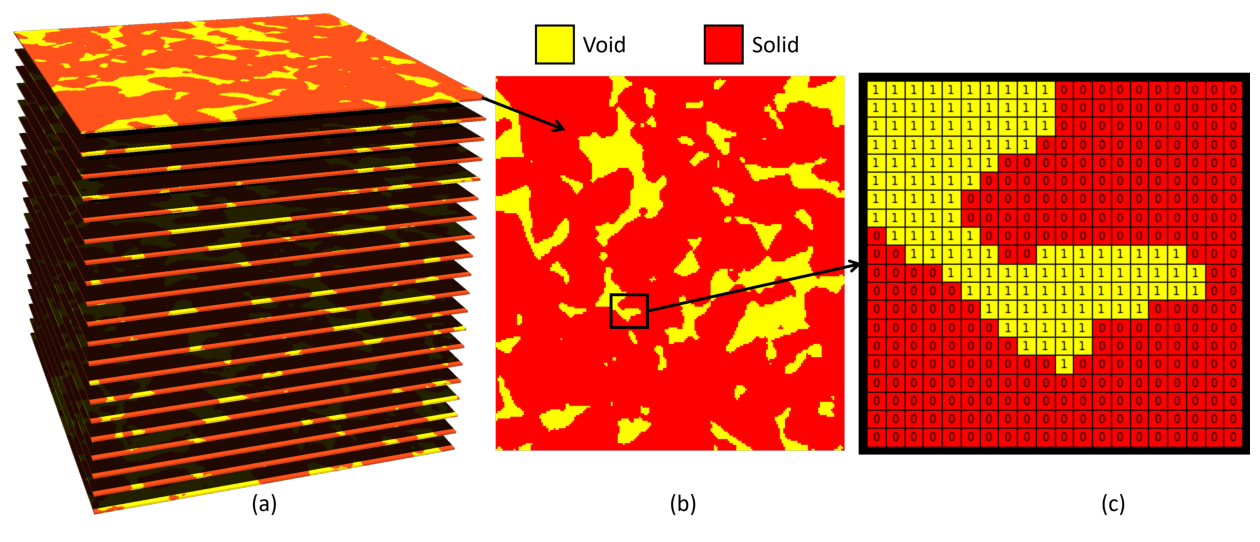

In [90]:
montage = imageio.v3.imread('images/tiff_stack_demo.png')
fig, ax = plt.subplots(1, 1, figsize=[16, 8])
ax.imshow(montage)
plt.axis(False);


## Image Segmentation: Identifying Solid and Void

One of the most important yet challenging steps is the filtering of noise from the greyscale images obtained experimentally.  As can be seen above the voxels inside the solid grains are generally brighter than the other phases, but this is only an average and there are lots of dark voxels in the grains.  This requires some averaging be applied to remove or smooth the noise.  For the sake of a simple demonstration, let's applie a median filter.

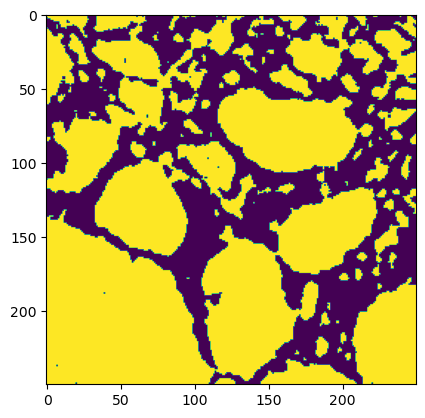

In [91]:
import scipy.ndimage as spim
im2 = spim.median_filter(im, 5)
plt.imshow(im2[..., 0] > 158);


After applying the ``median_filter`` we can find (by trial and error) that all voxels with a value higher than 158 belong to solid. 

Of course, a better filtering process should have been applied to really reduce the noise and aid this process.  It's important to get the correct because even a single stray voxel in the middle of a pore will drastically alter any quantitative analysis.

In [92]:
from skimage.restoration import non_local_means, estimate_sigma
im3 = (im - im.min())/(im.max() - im.min())
im3 = im3[..., 25]


In [93]:
s = estimate_sigma(im3)
im4 = non_local_means.denoise_nl_means(im3, sigma=s, patch_size=11, patch_distance=9, h=0.1)
im4 = (im4 - im4.min())/(im4.max() - im4.min())


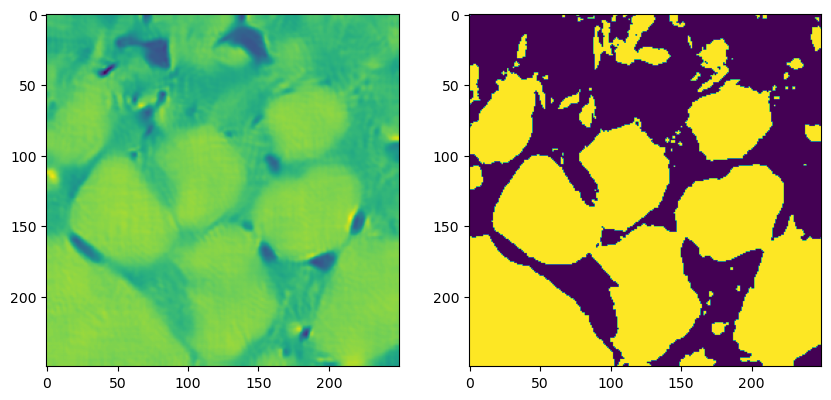

In [94]:
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
ax[0].imshow(im4)
ax[1].imshow(im4 > 0.73);
